<a href="https://colab.research.google.com/github/alexanderkersten/eae-dsaa/blob/main/decision_tree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Setup

- seaborn (0.13.1)
- pydotplus (2.0.2)
- scikit-learn (1.2.2)
- pandas (2.0.3)
- dtreeviz (2.2.2)
- graphviz (0.20.3)
- matplotlib (3.7.1)

In [ ]:
!pip install dtreeviz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 2.3 MB/s eta 0:00:00


In [10]:
import sklearn.datasets as datasets

iris = datasets.load_iris(as_frame=True)

# 2. Analysis

In [11]:
type(iris)

sklearn.utils._bunch.Bunch

In [12]:
print(iris.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

In [13]:
import pandas as pd

X = iris.data
y = iris.target

In [14]:
X.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [15]:
y.to_numpy()

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

<Axes: >

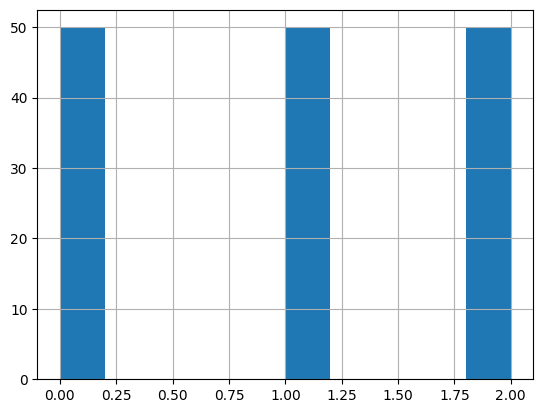

In [16]:
y.hist()

In [17]:
iris.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

In [21]:
iris_df = X.copy()
iris_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [22]:
species_dict = {0: 'setosa', 1: 'versicolor', 2: 'virginica'}
iris_df['species'] = y.map(species_dict)
iris_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


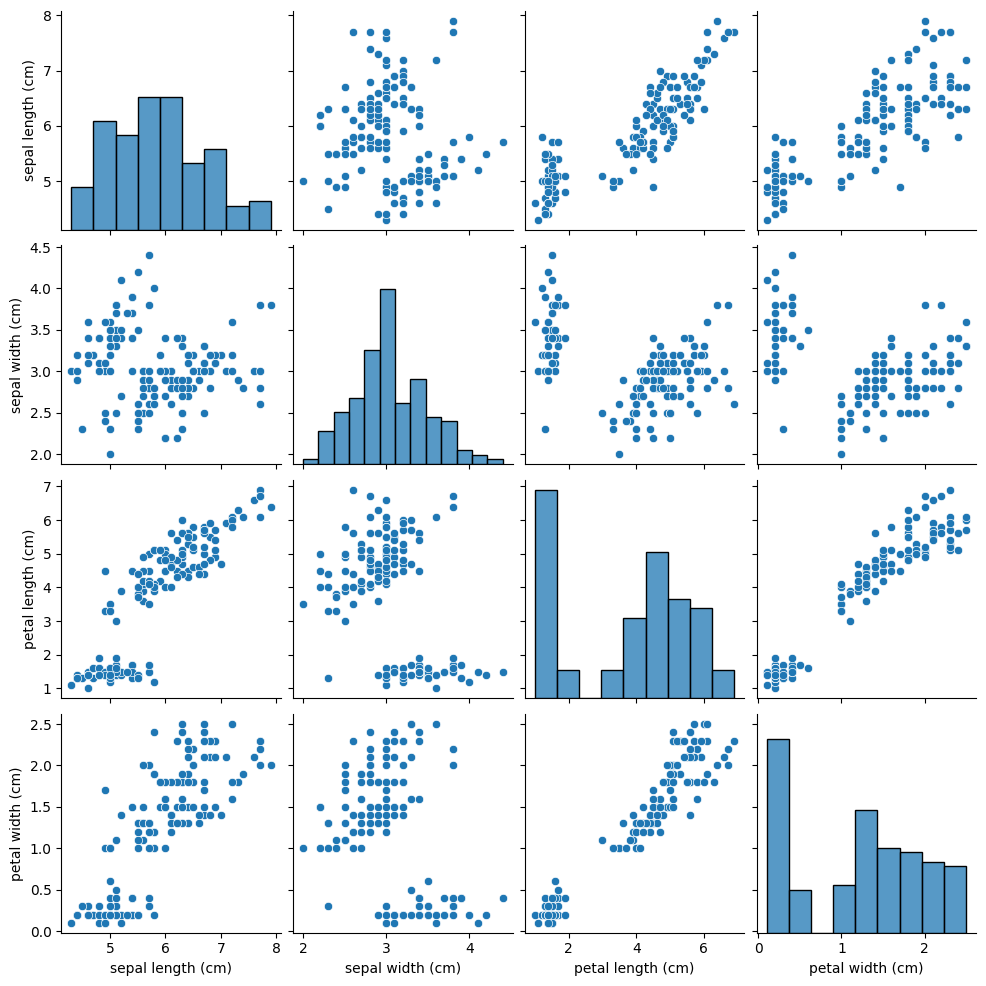

In [23]:
import seaborn as sns

sns.pairplot(iris_df)

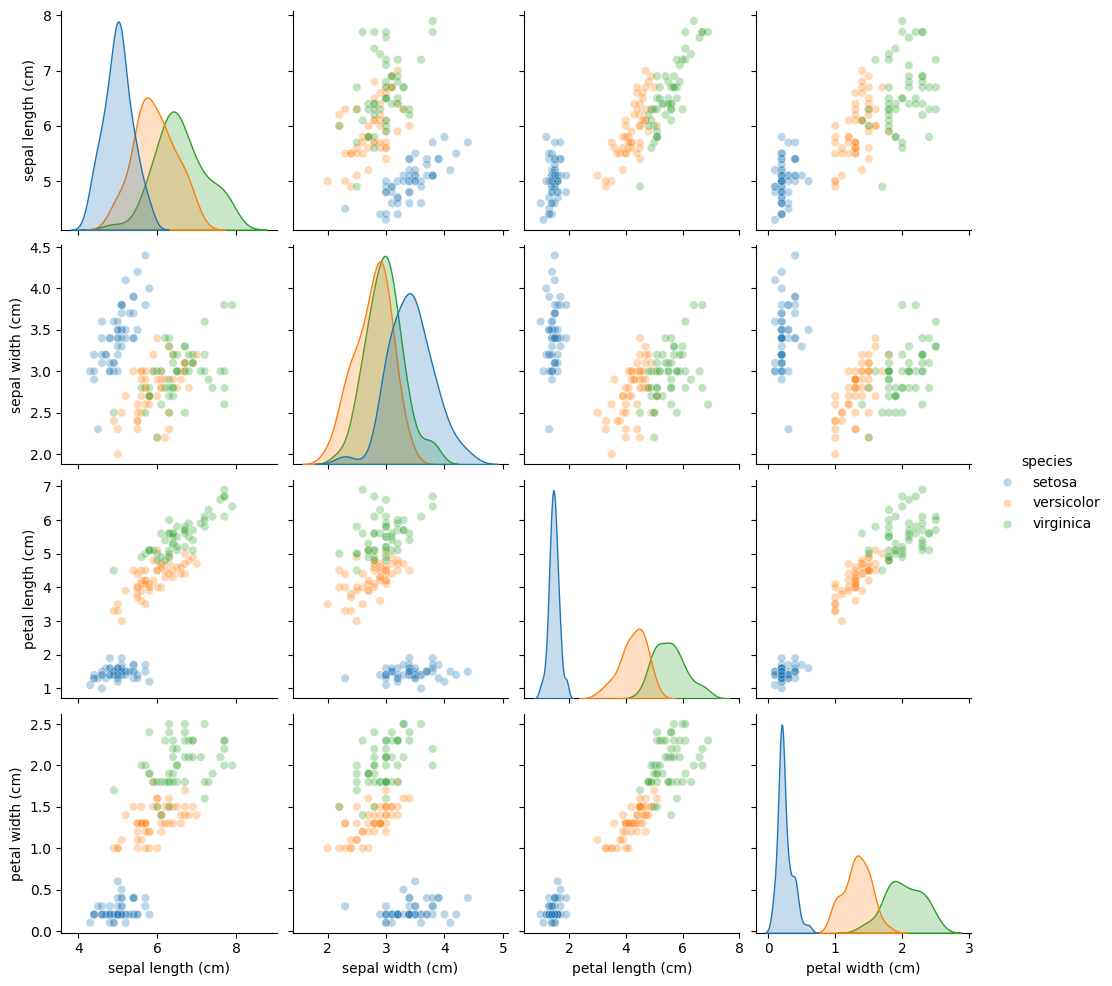

In [24]:
sns.pairplot(iris_df, hue='species', plot_kws=dict(alpha=0.3))

# 3. Preparation

# Decision Tree Machine Learning model

Decisions trees is a model following rule production systems, in which domain experts would create rules by hand:

In decision tree algorithms we're letting computers to discover these fluxograms automatically.

In decision trees we're creating structures like https://miro.com/blog/wp-content/uploads/2021/12/decision_tree_business_analysis.png

## Theory introduction

**Decision Trees** or CART (Classification and Regression Trees):

This method is based on the order of the data. It is, therefore, an iterative method in which each step will try to reduce the *impurity* of the data based on the variable to be predicted. Digging a bit:

1. We start with all our data in the same bag, therefore I have all the different categories mixed together.
By categories we mean the class, the target variable, i.e. what we're trying to predict in a classification task.

    1. The impurity of this data bag is modeled using the **Gini impurity index** (not to be confused with the Gini coefficient).
    1. Simplifying it, it could be seen as: If we introduce a new observation into our bag, whose response variable has been chosen based on the distribution of the different categories, what is the probability of being wrong if I try to classify it?
    1. In other terms: if I have a sack with two pears and two oranges, the impurity is 50%, since a new variable could be with the same probability either pear or orange.

2. Then, as we want to reduce this impurity, we will distribute the observations in different bags in each iteration based on the characteristics of our variables until we obtain groups where there is no possible error: Either everything is pears or everything is oranges.


# Dividing the dataset into train and test datasets

We are going to create a decision tree with a partition between train and test of the data. Look at the variable *random_state* that is applied in the `train_test_split` function. By changing this variable, the random distribution between the train and test data will change.

In [25]:
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=70)

In [27]:
len(X_train)

112

In [28]:
len(X_test)

38

# Why dividing the dataset is important ?

You want your model to generalize well, so sampling is important and you need to avoid data leakage, i.e. using the training dataset as the test dataset

Additional resources

- [K Fold Cross Validation](https://www.section.io/engineering-education/how-to-implement-k-fold-cross-validation/)

# Training a Decision Tree Classifier

In [29]:
from sklearn.tree import DecisionTreeClassifier

In [30]:
# Create the model
dtree = DecisionTreeClassifier()

# Train the model
# X_train contains the feature vectors for examples of flowers
# y_train contains the classes of these flowers
dtree.fit(X_train, y_train)

DecisionTreeClassifier()

## Exporting model to file

This can be used to create a flower classifier application, for example

In [ ]:
import pickle

# Saves file (serialized dtree object)
# wb stands for Write Binary
pickle.dump(dtree, open('dtree_iris.pkl', 'wb'))

In [ ]:
# Just showing the file was actually created
!ls | grep pkl

dtree_iris.pkl


### X and y notations

If you notice the name of the variables above, you'll see the X's and y's. Y is that?

In math notation, we define the dataset X as the array of feature vectors, each vector representing the description of a flower in our dataset, each feature representing an aspect of a flower). With all these values in X, we want to infer an approximate function $\hat{y}$, using the labeled dataset in variable `y` to better **fit** the data in `X`.

Or $\hat{y} = f(X)$

Here we also use 'y' as the name of the variable that holds the target variable (species)

## Visualizing resulting decision tree

In [31]:
import pydotplus
from io import StringIO
from IPython.display import Image
from sklearn.tree import export_graphviz

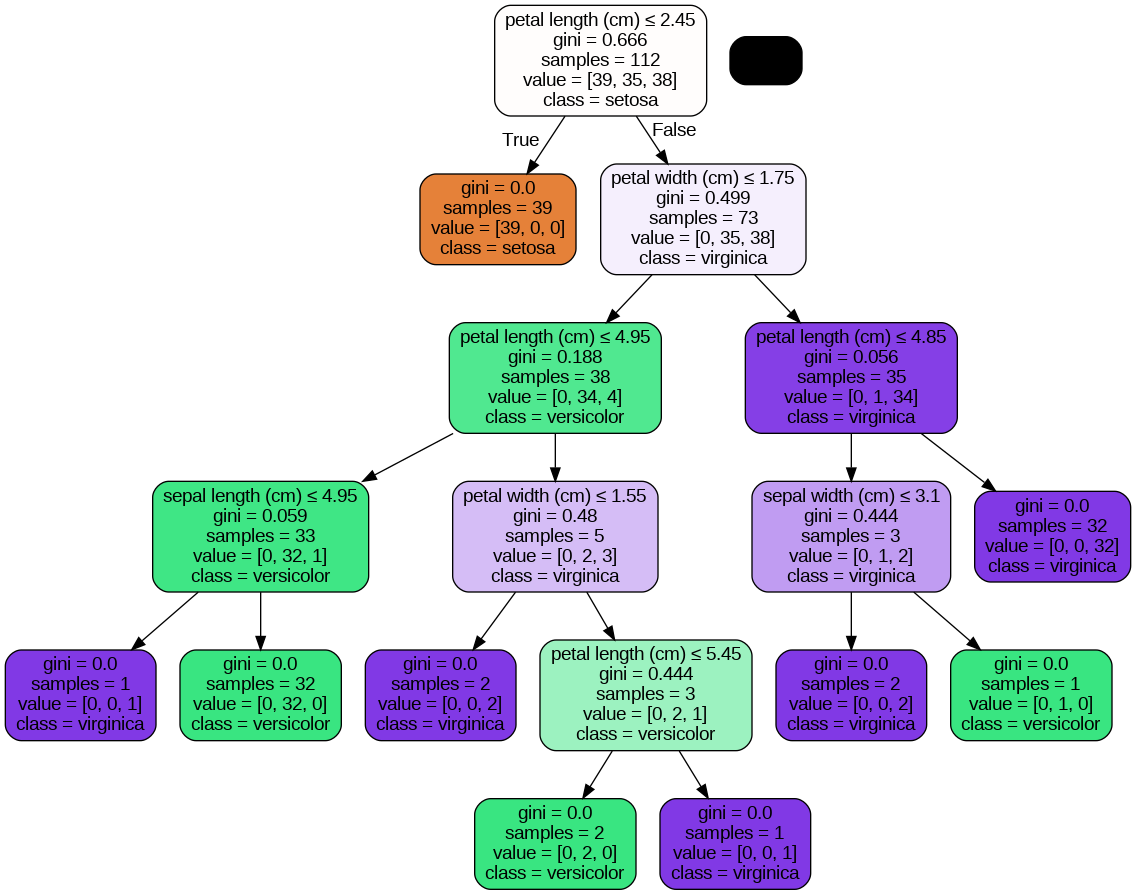

In [32]:
dot_data = StringIO()
export_graphviz(dtree,
                out_file=dot_data,
                feature_names=iris.feature_names,
                class_names=iris.target_names,
                filled=True,
                rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

We can see that there is a variable that strongly marks a first cut, so that already in the first split we obtain a partition without impurity. It is a model capable of obtaining a very accurate division of the data in very few steps.

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


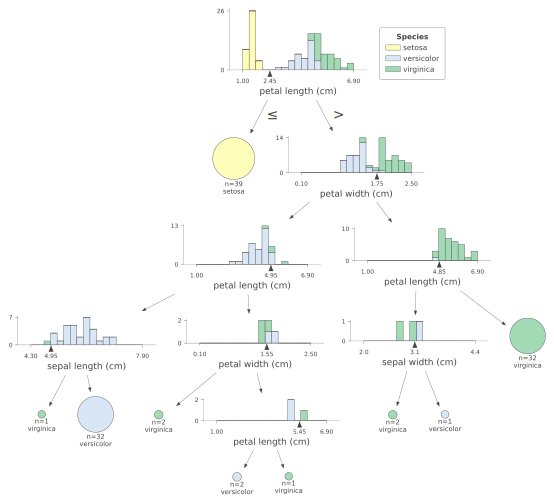

In [33]:
import dtreeviz
import matplotlib as mpl

viz = dtreeviz.model(dtree, X_train, y_train,
               target_name="Species",
               feature_names=iris.feature_names,
               class_names=list(iris.target_names))

viz.view(fontname="DejaVu Sans")

In [ ]:
# dtree.feature_names_in_ = None

### Let's test a different distribution of train/test data

If we now repeat this process with a different distribution between train and test, which implies that the model has been trained with other data, by changing `random_state` to other value ...

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


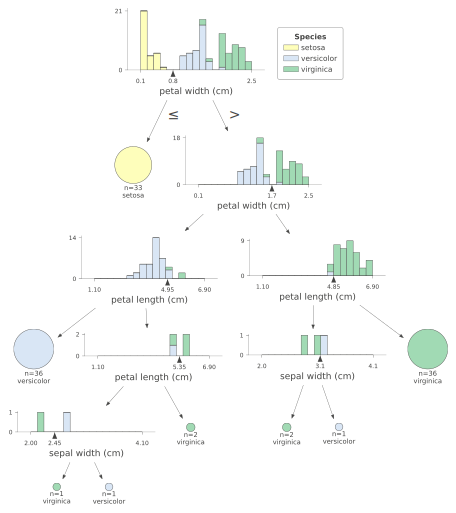

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=60)

dtree = DecisionTreeClassifier()
dtree.fit(X_train, y_train)

viz = dtreeviz.model(dtree, X_train, y_train,
               target_name="Species",
               feature_names=iris.feature_names,
               class_names=list(iris.target_names))

viz.view(fontname="DejaVu Sans")

In [ ]:
# Let's check the influence of the random_state variable
help(train_test_split)

Help on function train_test_split in module sklearn.model_selection._split:

train_test_split(*arrays, test_size=None, train_size=None, random_state=None, shuffle=True, stratify=None)
    Split arrays or matrices into random train and test subsets.
    
    Quick utility that wraps input validation,
    ``next(ShuffleSplit().split(X, y))``, and application to input data
    into a single call for splitting (and optionally subsampling) data into a
    one-liner.
    
    Read more in the :ref:`User Guide <cross_validation>`.
    
    Parameters
    ----------
    *arrays : sequence of indexables with same length / shape[0]
        Allowed inputs are lists, numpy arrays, scipy-sparse
        matrices or pandas dataframes.
    
    test_size : float or int, default=None
        If float, should be between 0.0 and 1.0 and represent the proportion
        of the dataset to include in the test split. If int, represents the
        absolute number of test samples. If None, the value is set to

## Some words about overfitting

Sometimes you train a ML algorithm on the labeled dataset you have but when faced with new unseen data the model starts performing bad, and therefore making wrong classifications. This happens because the model hasn't generalized the data patterns correctly. It was only replicating the data distribution in a highly specialized way.

That happens when the ML model overfits to the data it was presented and does not understand different kind of examples and patterns from unseen data.

### Overfitting in regression


### Overfitting in classification


### Overfitting in real life


# Train-validation-test split

One way to try to cope with overfitting is doing a more complex strategy for dividing the dataset into:

1. Train datased: used to train the model
1. Validation (or development) dataset: used to optimize our model parameters to achieve best accuracy possible
1. Test dataset: unseen data separated to test our model with possibly different patterns not found in previous datasets

In [35]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

X_train, X_dev, y_train, y_dev = train_test_split(
    X_train, y_train, test_size=0.10, random_state=42
)

# F-strings https://realpython.com/python-f-strings/
print(f'Training size: {len(X_train)}, Validation size: {len(X_dev)}, Test size: {len(X_test)}')

Training size: 100, Validation size: 12, Test size: 38


In [36]:
# Create the model
dtree = DecisionTreeClassifier()

# Train the model
dtree.fit(X_train, y_train)

DecisionTreeClassifier()

In [37]:
X_train.shape

(100, 4)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


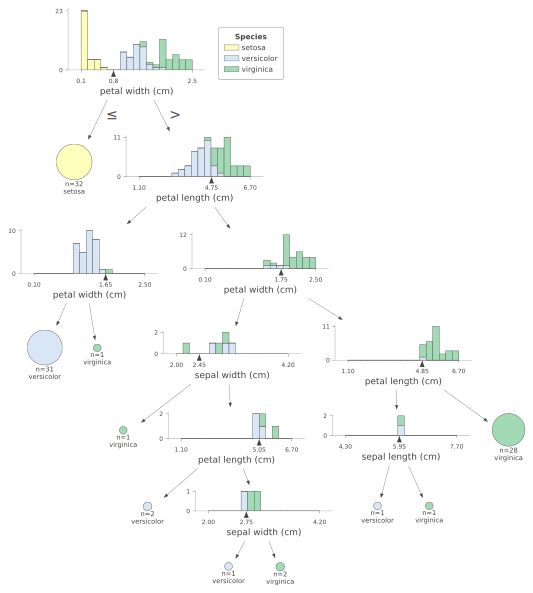

In [38]:
viz = dtreeviz.model(dtree, X_train, y_train,
               target_name="Species",
               feature_names=iris.feature_names,
               class_names=list(iris.target_names))

viz.view(fontname="DejaVu Sans")

## Checking accuracy with the validation dataset

In [39]:
from sklearn.metrics import confusion_matrix, accuracy_score

y_predicted = dtree.predict(X_dev)
y_predicted

array([0, 1, 1, 0, 2, 2, 1, 2, 1, 0, 2, 1])

In [40]:
print(f'Accuracy with validation {accuracy_score(y_dev, y_predicted)}')

Accuracy with validation 0.9166666666666666


At this point we can do multiple runs of train/validation checks to improve the accuracy score...

## Inferring over new unforeseen data (X_test)

In [41]:
# The same but with X_test, y_test
y_predicted = dtree.predict(X_test)
y_predicted

array([1, 0, 2, 1, 1, 0, 1, 2, 1, 1, 2, 0, 0, 0, 0, 1, 2, 1, 1, 2, 0, 2,
       0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 1, 0, 0, 2, 1, 0])

In [42]:
print(f'Accuracy with test dataset {accuracy_score(y_test, y_predicted)}')

Accuracy with test dataset 1.0


## Decision trees for regression problems

-  Additional resource: explained.ai

https://explained.ai/decision-tree-viz/index.html

### Diabetes dataset

Target is a quantitative measure of disease progression one year after baseline

In [ ]:
from IPython.display import Image


Image(url='https://explained.ai/decision-tree-viz/images/samples/diabetes-TD-3-X.svg')

In the above example we can see Decision Trees create **LINEAR** decision boundaries for its variables.
This is amazing to generate (visual) explanations for your resulting model BUT...



What would happen if the feature vector distribution is like in the image on the right?
That's why in the next class we're studying Support Vector Machines, able to divide the feature space into curved decision boundaries.

## Additional reading

- [A visual introduction to machine learning](http://www.r2d3.us/visual-intro-to-machine-learning-part-1/)
- [Understanding Decision Trees with Python](https://datascience.foundation/sciencewhitepaper/understanding-decision-trees-with-python)
- [4 Ways to Visualize Individual Decision Trees in a Random Forest](https://towardsdatascience.com/4-ways-to-visualize-individual-decision-trees-in-a-random-forest-7a9beda1d1b7)
- [How to Visualize a Random Forest with Fitted Parameters?](https://analyticsindiamag.com/how-to-visualize-a-random-forest-with-fitted-parameters/)
- [Understanding Random forest better through visualizations](https://garg-mohit851.medium.com/random-forest-visualization-3f76cdf6456f)

## Improving the Model

There are two very useful techniques that allow us to create new models:

* **Bootstrap**: It is based on choosing subsamples of our data in a uniform way and with repetition, thus creating multiple smaller samples that share the distributions of the original sample.

* **Bagging**: Generate a bootstrap of size $n$, train a model on that subsample and repeat the process $m$ times.

## Random Forests

Now let's apply an *ensemble* method such as *Random Forest*, based on the results of multiple decision trees.



There are other types of combining classifiers (or ensemble methods), such as mean average, or the product rule, using a priory probability distributions and the confidence of the classification of each classifier.

Additional reading:

- [Scikit Learn ensemble methods](https://scikit-learn.org/stable/modules/ensemble.html)

# Training a Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import matplotlib.pyplot as plt

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=100)

rf = RandomForestClassifier(n_jobs=-1) # parallelize the execution
rf.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1)

Let's analyze the code ... ([RFs in Scikit-Learn](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html))

In [ ]:
help(rf)

Help on RandomForestClassifier in module sklearn.ensemble._forest object:

class RandomForestClassifier(ForestClassifier)
 |  RandomForestClassifier(n_estimators=100, *, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None)
 |  
 |  A random forest classifier.
 |  
 |  A random forest is a meta estimator that fits a number of decision tree
 |  classifiers on various sub-samples of the dataset and uses averaging to
 |  improve the predictive accuracy and control over-fitting.
 |  The sub-sample size is controlled with the `max_samples` parameter if
 |  `bootstrap=True` (default), otherwise the whole dataset is used to build
 |  each tree.
 |  
 |  Read more in the :ref:`User Guide <forest>`.
 |  
 |  

## Real species

In [ ]:
y_test

array([2, 0, 2, 0, 2, 2, 0, 0, 2, 0, 0, 2, 0, 0, 2, 1, 1, 1, 2, 2, 2, 0,
       2, 0, 1, 2, 1, 0, 1, 2, 1, 1, 2, 0, 0, 1, 0, 1, 2, 2, 0, 1, 2, 2,
       0, 0, 0, 0, 1, 0])

## Predicting the class of test dataset

In [ ]:
predicted = rf.predict(X_test)
predicted

array([2, 0, 2, 0, 2, 2, 0, 0, 2, 0, 0, 2, 0, 0, 2, 1, 1, 2, 2, 2, 2, 0,
       2, 0, 1, 2, 1, 0, 1, 2, 1, 1, 1, 0, 0, 1, 0, 1, 2, 2, 0, 1, 2, 2,
       0, 0, 0, 0, 1, 0])

## Accuracy score

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score

In [ ]:
accuracy_score(y_test, predicted)

0.96

In [ ]:
help(accuracy_score)

Help on function accuracy_score in module sklearn.metrics._classification:

accuracy_score(y_true, y_pred, *, normalize=True, sample_weight=None)
    Accuracy classification score.
    
    In multilabel classification, this function computes subset accuracy:
    the set of labels predicted for a sample must *exactly* match the
    corresponding set of labels in y_true.
    
    Read more in the :ref:`User Guide <accuracy_score>`.
    
    Parameters
    ----------
    y_true : 1d array-like, or label indicator array / sparse matrix
        Ground truth (correct) labels.
    
    y_pred : 1d array-like, or label indicator array / sparse matrix
        Predicted labels, as returned by a classifier.
    
    normalize : bool, default=True
        If ``False``, return the number of correctly classified samples.
        Otherwise, return the fraction of correctly classified samples.
    
    sample_weight : array-like of shape (n_samples,), default=None
        Sample weights.
    
    Ret

# Feature importance

In [ ]:
rf = RandomForestClassifier(n_jobs=4)
rf

RandomForestClassifier(n_jobs=4)

In [ ]:
rf.fit(X_train, y_train)

RandomForestClassifier(n_jobs=4)

In [ ]:
importances = rf.feature_importances_
importances

array([0.08757588, 0.02555853, 0.46125792, 0.42560767])

In [ ]:
indexes = np.argsort(importances)[::-1]
indexes

array([2, 3, 0, 1])

In [ ]:
X.columns

Index(['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)',
       'petal width (cm)'],
      dtype='object')

In [ ]:
# Map importances to species_names
names = [X.columns[i] for i in indexes]
names

['petal length (cm)',
 'petal width (cm)',
 'sepal length (cm)',
 'sepal width (cm)']

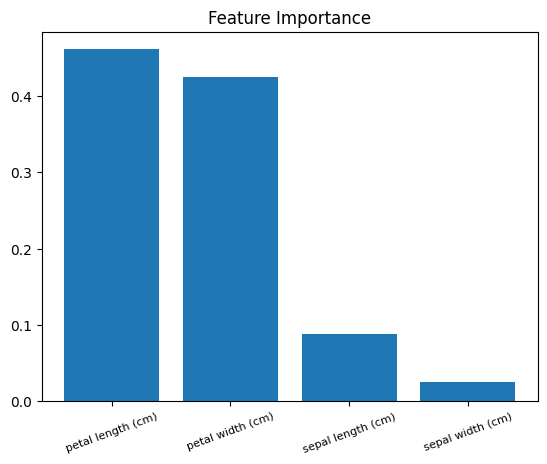

In [ ]:
# Prepare a barplot
plt.bar(range(X_train.shape[1]), importances[indexes])
# Add the feature names
plt.xticks(range(X_train.shape[1]), names, rotation=20, fontsize = 8)
# Add the title
plt.title("Feature Importance")
# Self explanatory...
plt.show()

In the code of the upper cell we see not only how we can apply a model, but that it contains the importance of the different *features* or predictor variables.

## Predict() function and confusion matrix

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix

rf_preds = rf.predict(X_test)
rf_conf_mat = confusion_matrix(y_test, rf_preds)
rf_conf_mat

array([[20,  0,  0],
       [ 0, 11,  1],
       [ 0,  1, 17]])

In [ ]:
help(confusion_matrix)

Help on function confusion_matrix in module sklearn.metrics._classification:

confusion_matrix(y_true, y_pred, *, labels=None, sample_weight=None, normalize=None)
    Compute confusion matrix to evaluate the accuracy of a classification.
    
    By definition a confusion matrix :math:`C` is such that :math:`C_{i, j}`
    is equal to the number of observations known to be in group :math:`i` and
    predicted to be in group :math:`j`.
    
    Thus in binary classification, the count of true negatives is
    :math:`C_{0,0}`, false negatives is :math:`C_{1,0}`, true positives is
    :math:`C_{1,1}` and false positives is :math:`C_{0,1}`.
    
    Read more in the :ref:`User Guide <confusion_matrix>`.
    
    Parameters
    ----------
    y_true : array-like of shape (n_samples,)
        Ground truth (correct) target values.
    
    y_pred : array-like of shape (n_samples,)
        Estimated targets as returned by a classifier.
    
    labels : array-like of shape (n_classes), default=

# You can get the accuracy score with data from confusion matrix

In [ ]:
# Convert to numpy
np_mat = np.asarray(rf_conf_mat)

acc = sum(np.diagonal(np_mat)) / np_mat.sum()
print(f"My accuracy is: {acc}")

My accuracy is: 0.96


# Confusion matrix visualization

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

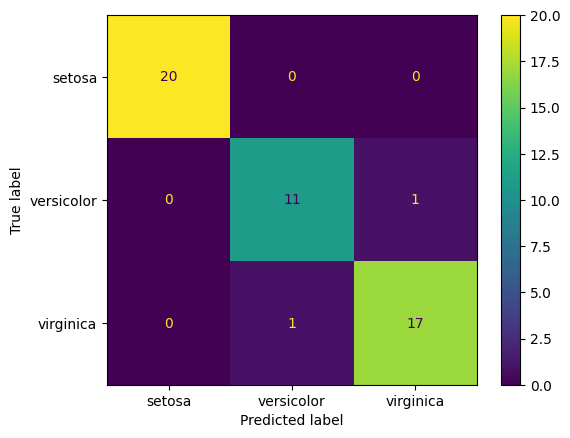

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=rf_conf_mat,display_labels=iris.target_names)
disp.plot()